In [1]:
import random

import networkx as nx
from matplotlib import pyplot as plt

In [2]:
path = "data/mici/dolphins/dolphins.gml"
graph = nx.read_gml(path, label='id')

In [3]:
# sol_path = input("Path class: ")

In [4]:
vertices = list(graph.nodes())
node_to_index = {node: index for index, node in enumerate(vertices)}
edges = list(graph.edges)

In [5]:
class Chromosome:
    def __init__(self, problem_param_arg=None):
        self.__problem_param = problem_param_arg
        self.__representation = [random.randint(1, problem_param_arg['noVertices']) for _ in
                                 range(problem_param_arg['noVertices'])]
        self.__fitness = 0.0

    @property
    def representation(self):
        return self.__representation

    @property
    def fitness(self):
        return self.__fitness

    @representation.setter
    def representation(self, representation=None):
        if representation is None:
            representation = [random.randint(1, self.__problem_param['noVertices']) for _ in
                              range(self.__problem_param['noVertices'])]
        self.__representation = representation

    @fitness.setter
    def fitness(self, fit=0.0):
        self.__fitness = fit

    def crossover(self, c: 'Chromosome'):
        r = random.randint(0, len(self.__representation) - 1)
        new_representation = []
        for i in range(r):
            new_representation.append(self.__representation[i])
        for i in range(r, len(self.__representation)):
            new_representation.append(c.__representation[i])
        offspring = Chromosome(c.__problem_param)
        offspring.representation = new_representation
        return offspring

    def mutation(self):
        pos = random.randint(0, len(self.__representation) - 1)
        self.__representation[pos] = random.randint(1, self.__problem_param['noVertices'])


    def __str__(self):
        return '\nChromo: ' + str(self.__representation) + ' has fit: ' + str(self.__fitness)
    
    
    def __repr__(self):
        return self.__str__()
    
    
    def __eq__(self, c):
        return self.__representation == c.__repres and self.__fitness == c.__fitness

In [6]:
class GA:
    def __init__(self, param=None, problem_param=None):
        self.__param = param
        self.__problem_param = problem_param
        self.__population = []

    @property
    def population(self):
        return self.__population

    def initialization(self):
        for _ in range(0, self.__param['popSize']):
            c = Chromosome(self.__problem_param)
            self.__population.append(c)

    def evaluation(self):
        for c in self.__population:
            c.fitness = self.__problem_param['fitness'](c.representation)

    def selection(self):
        pos1 = random.randint(0, self.__param['popSize'] - 1)
        pos2 = random.randint(0, self.__param['popSize'] - 1)
        if self.__param['cmp'](self.__population[pos1].fitness, self.__population[pos2].fitness):
            return pos2
        else:
            return pos1

    # def next_generation(self):
    #     new_pop = []
    #     self.__population: list[Chromosome]
    #     for _ in range(self.__param['popSize']):
    #         p1 = self.__population[self.selection()]
    #         p2 = self.__population[self.selection()]
    #         child = p1.crossover(p2)
    #         child.mutation()
    #         new_pop.append(child)
    #     self.__population = new_pop
    #     self.evaluation()
    def next_generation(self):
        new_pop = []
        self.__population.sort(key=lambda x: x.fitness, reverse=True)  # sort the population by fitness
        elites = self.__population[:self.__param['elitism']]  # select the top 'elitism' individuals
        new_pop.extend(elites)  # add the elites to the new population

        for _ in range(self.__param['popSize']):
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            child = p1.crossover(p2)
            child.mutation()
            new_pop.append(child)

        self.__population = new_pop
        self.evaluation()

    def best_chromosome(self):
        best_c = self.__population[0]
        for c in self.__population:
            if self.__param['cmp'](best_c.fitness, c.fitness):
                best_c = c
        return best_c

In [7]:
def modularity(communities: list[int]):
    global node_to_index, vertices, edges
    m = len(edges)
    q = 0
    node_to_index = {node: index for index, node in enumerate(vertices)}  # map each node to a unique index
    for community in set(communities):
        e = 0
        a = 0
        for edge in edges:
            if communities[node_to_index[edge[0]]] == communities[node_to_index[edge[1]]] == community:
                e += 1
            if communities[node_to_index[edge[0]]] == community or communities[node_to_index[edge[1]]] == community:
                a += 1
        e /= m
        a = a / (2 * m)
        q += e - a ** 2
    return q


def compute_degree(node: int):
    degree = 0
    for edge in edges:
        if edge[0] == node:
            degree += 1

    return degree


def compute_inter_community_degree(communities: list[int], community, node):
    result = 0
    for edge in edges:
        if edge[0] == node:
            if communities[edge[1]] != community:
                result += 1

    return result


def average_odf(communities: list[int]):
    total_odf = 0
    community_count = 0
    for community in set(communities):
        community_odf = 0
        community_node_count = 0
        for node in vertices:
            if communities[node] != community:
                continue
            out_degree = compute_degree(node)
            inter_community_degree = compute_inter_community_degree(communities, community, node)
            odf = inter_community_degree / out_degree if out_degree > 0 else 0
            community_odf += odf
            community_node_count += 1
        if community_node_count > 0:
            total_odf += community_odf / community_node_count
            community_count += 1
    return total_odf / community_count if community_count > 0 else 0


def compute_average_conductance(communities: list[int]):
    conductance_scores = []
    for community in set(communities):
        community_edges = 0
        total_edges = 0
        for edge in edges:
            if communities[edge[0]] == communities[edge[1]] == community:
                community_edges += 1
            if communities[edge[0]] == community or communities[edge[1]] == community:
                total_edges += 1
        conductance = 1 - (community_edges / total_edges) if total_edges > 0 else 0
        conductance_scores.append(conductance)
    return sum(conductance_scores) / len(conductance_scores) if conductance_scores else 0

In [8]:
def modularity_comp(a, b):
    return a < b


def conductance_comp(a, b):
    return a > b


param = {
    'popSize': 25,
    'cmp': modularity_comp,
    'elitism': 1
}
problem_param = {
    'noVertices': len(vertices),
    'fitness': modularity
}

In [9]:
def plot_solutions(solutions, fitness):
    # Convert solutions to a format suitable for plotting
    x = [index for index, s in enumerate(solutions)]

    # Create a scatter plot
    plt.scatter(x, fitness)

    # Set plot title and labels
    plt.title('Solutions and their fitness values')
    plt.xlabel('Solution')
    plt.ylabel('Fitness')

    # Show the plot
    plt.show()

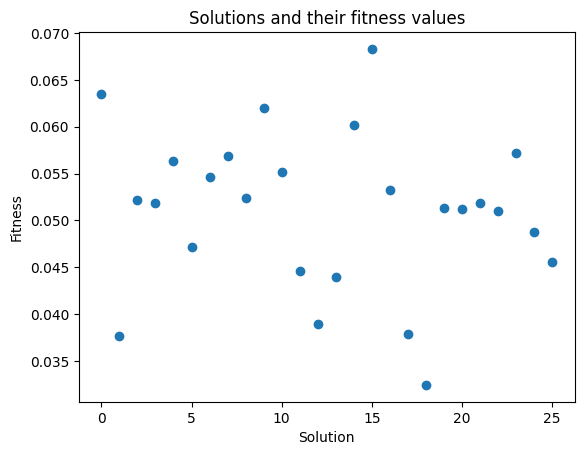

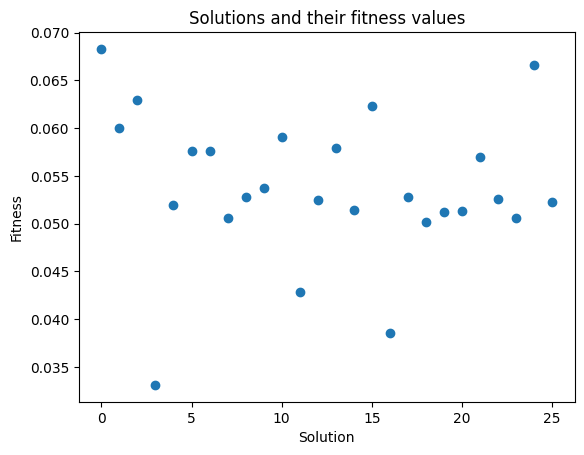

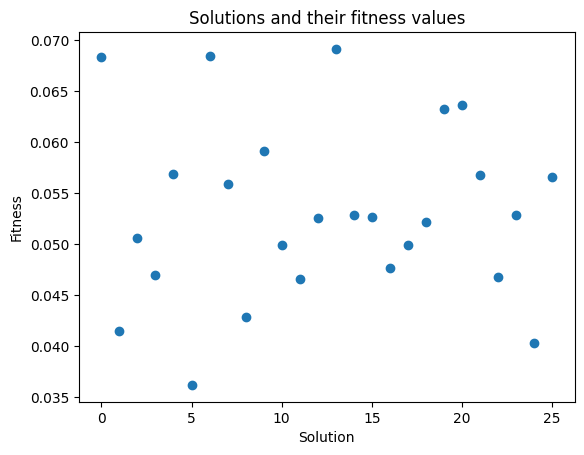

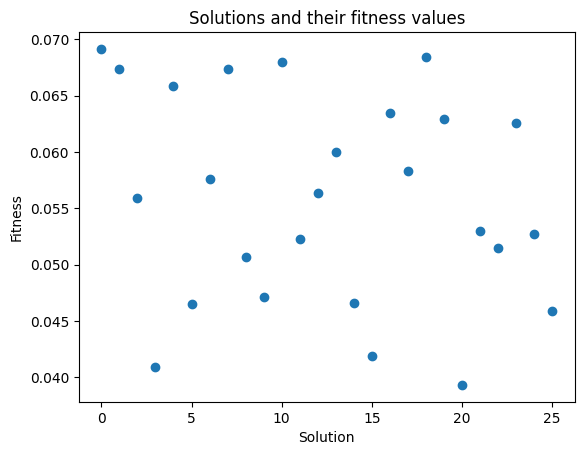


Chromo: [14, 19, 39, 22, 48, 40, 34, 33, 27, 29, 14, 38, 9, 31, 56, 51, 9, 34, 41, 45, 20, 19, 10, 40, 53, 27, 25, 3, 12, 60, 12, 34, 16, 9, 50, 12, 61, 6, 56, 28, 14, 33, 31, 6, 22, 47, 28, 20, 46, 53, 9, 47, 40, 54, 33, 40, 23, 46, 27, 27, 58, 8] has fit: 0.06913294569043948


In [10]:
ga = GA(param, problem_param)
ga.initialization()
s = []
f = []
b = None
for i in range(25):
    ga.evaluation()
    solutions = [c.representation for c in ga.population]
    fitness = [c.fitness for c in ga.population]
    best = ga.best_chromosome()
    s = solutions
    f = fitness
    b = best

    # print(f'Solutiile sunt:')
    # for x in ga.population:
    #     print(str(x), end=' ')
    # print()
    if i > 20:
        plot_solutions(solutions, fitness)
    ga.next_generation()

# print(s)
# print(f)
print(str(b))